In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('/content/powerconsumption.csv')

# Step 1: Data Preprocessing
# Convert 'Datetime' to a datetime object and extract useful time features
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['Hour'] = data['Datetime'].dt.hour
data['Day'] = data['Datetime'].dt.day
data['Month'] = data['Datetime'].dt.month

# Exclude 'Datetime' from scaling as it's not a numerical feature
numerical_features = data.select_dtypes(include=np.number).columns.tolist()

# Normalize the dataset using MinMaxScaler only on numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numerical_features])

# Convert scaled data back to a DataFrame for easier manipulation
scaled_data = pd.DataFrame(scaled_data, columns=numerical_features, index=data.index)
# Concatenate scaled numerical features with original 'Datetime'
features_for_model = scaled_data.drop(columns=['Datetime'], errors='ignore')

In [ ]:
# Step 2: Prepare input (X) and output (y)
# Use past 'n_steps' timesteps to predict the target variable
n_steps = 10  # Number of timesteps
target = 'PowerConsumption_Zone1'

X = []
y = []

for i in range(n_steps, len(scaled_data)):
    # Use features_for_model for input sequences
    X.append(features_for_model.iloc[i-n_steps:i].values)
    y.append(scaled_data.iloc[i][target])        # Target at current timestep

X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the GRU Model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, activation='tanh', input_shape=(n_steps, X.shape[2])),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(units=64, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)  # Regression output
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Model Summary
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 10, 128)             │          54,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,505 (365.25 KB)

 Trainable params: 93,505 (365.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Step 5: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Mean Absolute Error: {test_mae:.4f}")

Epoch 1/20
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.0127 - mae: 0.0724 - val_loss: 5.3106e-04 - val_mae: 0.0170
Epoch 2/20
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 4.6446e-04 - val_mae: 0.0166
Epoch 3/20
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - loss: 8.8490e-04 - mae: 0.0223 - val_loss: 2.4493e-04 - val_mae: 0.0114
Epoch 4/20
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 6.7467e-04 - mae: 0.0196 - val_loss: 1.9472e-04 - val_mae: 0.0100
Epoch 5/20
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 5.9570e-04 - mae: 0.0182 - val_loss: 2.1525e-04 - val_mae: 0.0109
Epoch 6/20
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 5.3749e-04 - mae: 0.0176 - val_loss: 2.8038e-04 - val_mae: 0.0128
Epoch 7/20
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 4.8049e-04 - mae: 0.0164 - val_loss: 3.1926e-04 - val_mae: 0.0141
Epoch 8/20
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 4.8424e-04 - mae: 0.0163 - val_los

In [ ]:
predictions = model.predict(X_test)
print(X_test.shape)

328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
(10482, 10, 11)


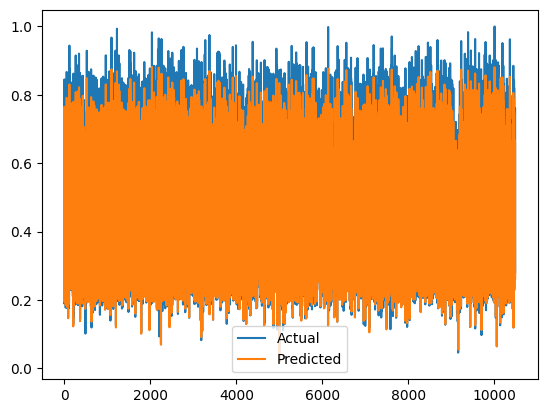

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()
